In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from __future__ import print_function, division
import mdtraj as md
from tmtools import tm_align

In [3]:
def my_tm_align(coords1, coords2):
    return tm_align(coords1, coords2, "x"*coords1.shape[0], "x"*coords2.shape[0])

In [4]:
def get_similarity_score(path1, path2, chain1, chain2):
    pdb1 = md.load(path1)
    pdb2 = md.load(path2)
    chain_id_to_index1 = {}
    for chain in pdb1.topology.chains:
        if chain.chain_id not in chain_id_to_index1:
            chain_id_to_index1[chain.chain_id] = chain.index
    CAs1 = pdb1.topology.select(f'name CA and chainid {chain_id_to_index1[chain1]}')
    pdb1_CAs = pdb1.atom_slice(CAs1)
    chain_id_to_index2 = {}
    for chain in pdb2.topology.chains:
        if chain.chain_id not in chain_id_to_index2:
            chain_id_to_index2[chain.chain_id] = chain.index
    CAs2 = pdb2.topology.select(f'name CA and chainid {chain_id_to_index2[chain2]}')
    pdb2_CAs = pdb2.atom_slice(CAs2)
    tm = my_tm_align(pdb1_CAs.xyz.reshape(-1,3)*10, pdb2_CAs.xyz.reshape(-1,3)*10)
    return tm.tm_norm_chain1

In [5]:
def get_similarity_score_local(path1, path2, region1, region2, chain1, chain2):
    pdb1 = md.load(path1)
    pdb2 = md.load(path2)
    chain_id_to_index1 = {}
    for chain in pdb1.topology.chains:
        if chain.chain_id not in chain_id_to_index1:
            chain_id_to_index1[chain.chain_id] = chain.index
    CAs1 = pdb1.topology.select(f'name CA and chainid {chain_id_to_index1[chain1]}')
    CAs1_region = CAs1[region1[0]:region1[1]]
    pdb1_CAs = pdb1.atom_slice(CAs1_region)
    chain_id_to_index2 = {}
    for chain in pdb2.topology.chains:
        if chain.chain_id not in chain_id_to_index2:
            chain_id_to_index2[chain.chain_id] = chain.index
    CAs2 = pdb2.topology.select(f'name CA and chainid {chain_id_to_index2[chain2]}')
    CAs2_region = CAs2[region2[0]:region2[1]]
    pdb2_CAs = pdb2.atom_slice(CAs2_region)
    tm = my_tm_align(pdb1_CAs.xyz.reshape(-1,3)*10, pdb2_CAs.xyz.reshape(-1,3)*10)
    return tm.tm_norm_chain1

In [6]:
# read csv to df
df = pd.read_csv("results/prostt5_regions.csv")
df

,pairname,comparison_id,prot1,chain1,prot2,chain2,protein1_residues,protein2_residues,alignment_score
0,d1a05a_-A_183-d1dgsa3-A_184,d1a05a_d1dgsa3,d1a05a_,A,d1dgsa3,A,"(111, 156)","(147, 192)",67.865046
1,d1a05a_-A_185-d1j71a_-A_186,d1a05a_d1j71a_,d1a05a_,A,d1j71a_,A,"(83, 112)","(135, 164)",57.191404
2,d1a05a_-A_187-d1rblm_-M_188,d1a05a_d1rblm_,d1a05a_,A,d1rblm_,M,"(160, 177)","(18, 35)",36.232130
3,d1a2za_-A_0-d1ghha_-A_1,d1a2za_d1ghha_,d1a2za_,A,d1ghha_,A,"(189, 206)","(55, 72)",32.900426
4,d1a2za_-A_2-d1u9da_-A_3,d1a2za_d1u9da_,d1a2za_,A,d1u9da_,A,"(189, 213)","(77, 101)",53.057260
...,...,...,...,...,...,...,...,...,...
143,d2gaw.1-A_174-d1nppa1-A_176,d2gaw.1d1nppa1,d2gaw.1,A,d1nppa1,A,"(0, 29)","(6, 36)",57.386746
144,d2gaw.1-B_175-d1nppa1-A_176,d2gaw.1d1nppa1,d2gaw.1,B,d1nppa1,A,"(46, 76)","(7, 37)",57.695120
145,d2onea1-A_177-d1hz6b_-B_178,d2onea1d1hz6b_,d2onea1,A,d1hz6b_,B,"(1, 23)","(0, 22)",43.971381
146,d3pmga1-A_179-d1e8ca1-A_180,d3pmga1d1e8ca1,d3pmga1,A,d1e8ca1,A,"(387, 413)","(302, 328)",63.580819


In [7]:
id_list = df["comparison_id"].tolist()
region1_list = df["protein1_residues"].tolist()
region2_list = df["protein2_residues"].tolist()
chain1_list = df["chain1"].tolist()
chain2_list = df["chain2"].tolist()

In [8]:
analogs_folder = "../datasets/analogs_complete"

In [9]:
similarity_scores = []
similarity_local_scores = []

for i in tqdm(range(len(id_list))):
    try:
        id = id_list[i]
        region1 = eval(region1_list[i])
        region2 = eval(region2_list[i])
        pair_folder = os.path.join(analogs_folder, id)
        pair_paths = glob(os.path.join(pair_folder, "*.pdb"))
        #print(pair_paths)
        #print(pair_paths)
        id1, id2 = id[1:5], id[8:12]
        #print(f"Processing pair: {id1}, {id2}")
        path1, path2 = None, None
        for path in pair_paths:
            if id1 in path.split("/")[-1]:
                path1 = path
            elif id2 in path.split("/")[-1]:
                path2 = path
        #print(f"Paths: {path1}, {path2}, Regions: {region1}, {region2}, Chains: {chain1_list[i]}, {chain2_list[i]}")
        similarity = get_similarity_score(path1, path2, chain1_list[i], chain2_list[i])
        similarity_local = get_similarity_score_local(path1, path2, region1, region2, chain1_list[i], chain2_list[i])
        similarity_scores.append(similarity)
        similarity_local_scores.append(similarity_local)  
    except Exception as e:
        print(f"Error processing {id}: {e}")
        continue

  2%|▏         | 3/148 [00:03<03:17,  1.36s/it]/home/zim003/miniforge3/envs/process/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:208: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(
100%|██████████| 148/148 [02:29<00:00,  1.01s/it]


In [10]:
len(similarity_scores), len(similarity_local_scores)

(148, 148)

In [11]:
# count the number of similarity scores that are greater than 0.5 and less than 0.1
count_greater_05 = sum(1 for score in similarity_local_scores if score > 0.5)
count_greater_04 = sum(1 for score in similarity_local_scores if score > 0.4)
count_less_01 = sum(1 for score in similarity_local_scores if score < 0.1)
print(f"Number of local similarity scores greater than 0.5: {count_greater_05}")
print(f"Number of local similarity scores greater than 0.4: {count_greater_04}")
print(f"Number of local similarity scores less than 0.1: {count_less_01}")

Number of local similarity scores greater than 0.5: 53
Number of local similarity scores greater than 0.4: 93
Number of local similarity scores less than 0.1: 4


In [12]:
# print the mean and standard deviation of similarity_local_scores （.3format）(±)
print(f"{np.mean(similarity_local_scores):.3f}±{np.std(similarity_local_scores):.3f}")
# print the mean and standard deviation of similarity_scores （.3format）(±)
print(f"{np.mean(similarity_scores):.3f}±{np.std(similarity_scores):.3f}")

0.433±0.142
0.257±0.110


In [13]:
# maen and std of all length of the regions
lengths = []
for region in region1_list:
    region_eval = eval(region)
    lengths.append(region_eval[1] - region_eval[0])
for region in region2_list:
    region_eval = eval(region)
    lengths.append(region_eval[1] - region_eval[0])
print(f"{np.mean(lengths):.1f}±{np.std(lengths):.1f}")

29.7±16.5


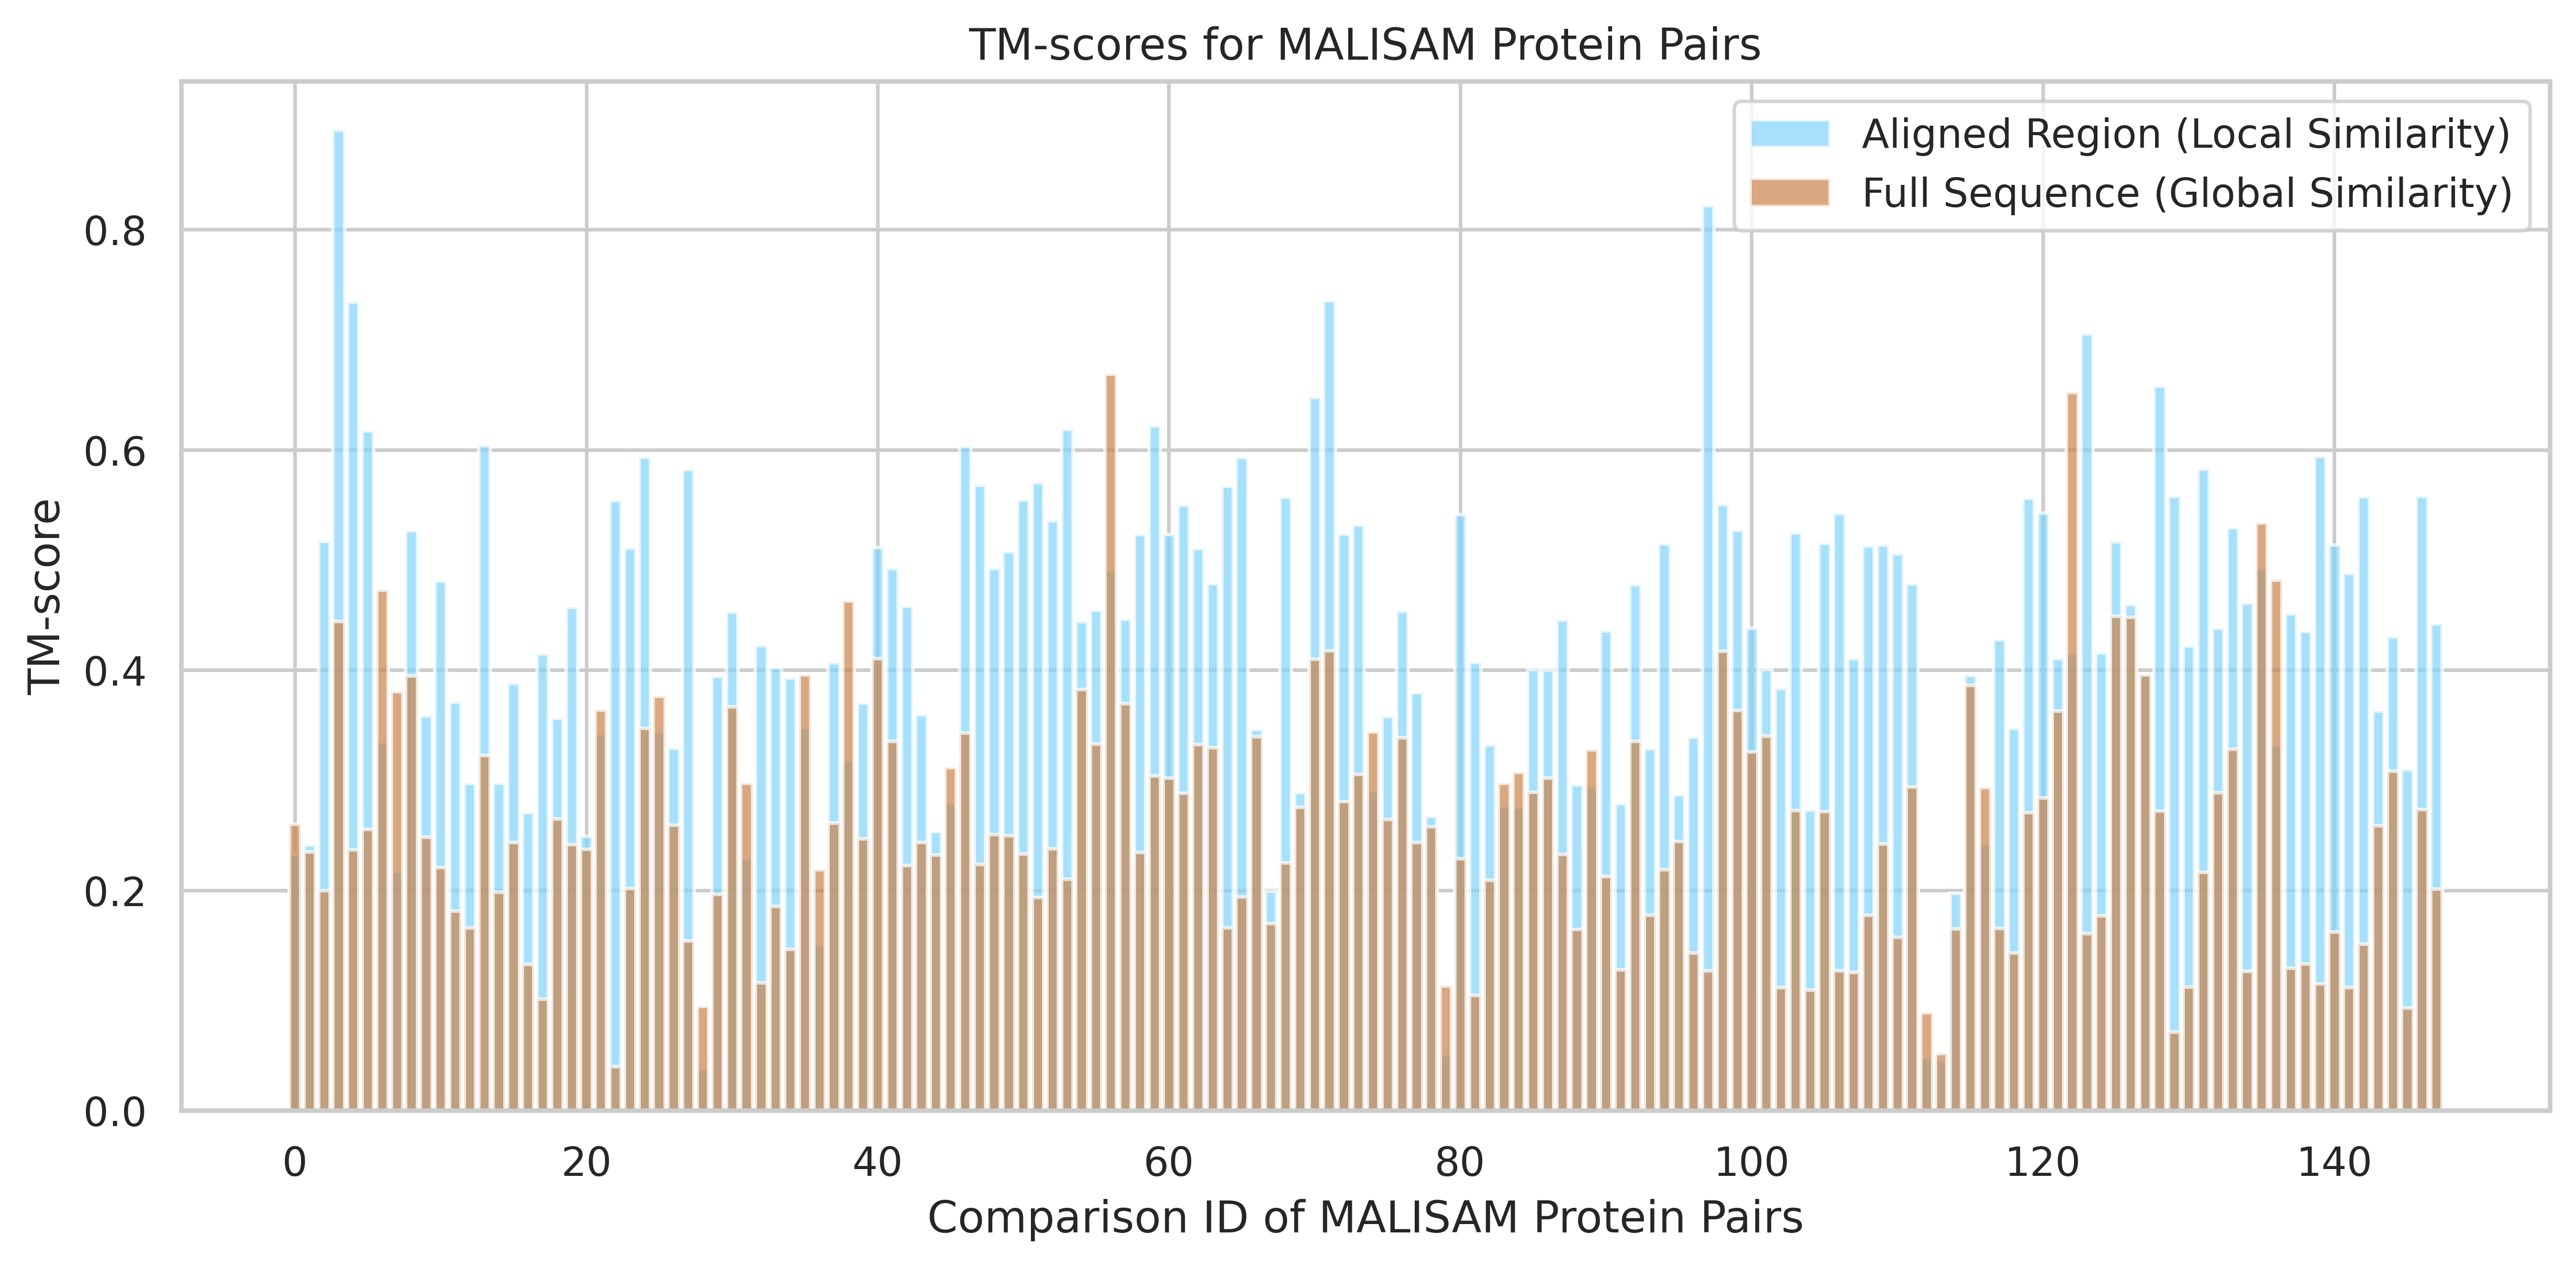

In [14]:
# bar plot of similarity scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5), dpi=500)
plt.bar(range(len(similarity_local_scores)), similarity_local_scores, color="#82D4FA", alpha=0.7, label='Aligned Region (Local Similarity)')
plt.bar(range(len(similarity_scores)), similarity_scores, color="#C9844B", alpha=0.7, label='Full Sequence (Global Similarity)')
plt.xlabel('Comparison ID of MALISAM Protein Pairs')
plt.ylabel('TM-score')
plt.title('TM-scores for MALISAM Protein Pairs')
plt.legend()
plt.tight_layout()
plt.show()